In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid", palette="Set2")

pd.set_option("display.max_columns", 100)

CSV_PATH = Path("data/biroylikgarovlilar_redone.csv")
REPORTS_DIR = Path("reports"); REPORTS_DIR.mkdir(exist_ok=True)

df = pd.read_csv(CSV_PATH)
df.head()

,Код,Наименование,Облать,Город/район,Номер,Дата,Сумма,% ставка,Гос.номер,Марка,Тип кузова,Тип,Цвет,Год выпуска,Страна производитель
0,99224744,RAXIMOVA QIMMATXON SULAYMONOVNA,АНДИЖОН ВИЛОЯТИ,АСАКА ТУМАНИ,02-1468/25K,01.08.2025,"30,000,000.00",48.0,60B960AB,MALIBU,SEDAN,Легковые автомобили,ОЛИМПИЙСКИЙ БЕЛЫЙ,2012,Узбекистан
1,99224753,NAZAROVA MUXABBAT BAYNAZAROVNA,АНДИЖОН ВИЛОЯТИ,АНДИЖОН ТУМАНИ,02-1469/25K,01.08.2025,"30,000,000.00",48.0,60C634ZA,COBALT,SEDAN,Легковые автомобили,KULRANG SEROPERLAMUTROVIY,2014,Узбекистан
2,99137961,Komilov Muxammad Ali Baxriddin o’g’li,АНДИЖОН ВИЛОЯТИ,АСАКА ТУМАНИ,02-1470/25K,01.08.2025,"28,000,000.00",48.0,60Z871DB,SPARK,XETCHBEK,Легковые автомобили,СЕРЕБРИСТЫЙ,2015,Узбекистан
3,99101300,Ruziboyev Ilxomjon Kosimovich,АНДИЖОН ВИЛОЯТИ,МАРХАМАТ ТУМАНИ,02-1471/25K,01.08.2025,"20,000,000.00",48.0,60L218EB,LACETTI,SEDAN,Легковые автомобили,KULRANG SEREBRISTIY,2015,Узбекистан
4,99224814,JALOLOV ANVAR MUXAMADAMINOVICH,АНДИЖОН ВИЛОЯТИ,МАРХАМАТ ТУМАНИ,02-1472/25K,01.08.2025,"99,000,000.00",42.0,60K839EB,LACETTI,SEDAN,Легковые автомобили,DARKMOON BLUE MET,2023,Узбекистан


In [2]:
print("Shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
df.info()

Shape: (492, 15)

Column names: ['Код', 'Наименование', 'Облать', 'Город/район', 'Номер', 'Дата', 'Сумма', '% ставка', 'Гос.номер', 'Марка', 'Тип кузова', 'Тип', 'Цвет', 'Год выпуска', 'Страна производитель']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Код                   492 non-null    int64  
 1   Наименование          492 non-null    object 
 2   Облать                492 non-null    object 
 3   Город/район           492 non-null    object 
 4   Номер                 492 non-null    object 
 5   Дата                  492 non-null    object 
 6   Сумма                 492 non-null    object 
 7   % ставка              492 non-null    float64
 8   Гос.номер             492 non-null    object 
 9   Марка                 492 non-null    object 
 10  Тип кузова            492 non-null    object 
 11  Тип               

In [3]:
df["Дата"] = pd.to_datetime(df["Дата"], dayfirst=True, errors="coerce")

df["Сумма_num"] = (df["Сумма"].astype(str)
                   .str.replace(",", "", regex=False)
                   .str.replace(" ", "", regex=False)
                   .astype(float))

df["Возраст авто"] = df["Дата"].dt.year - df["Год выпуска"]

df[["Сумма", "Сумма_num", "% ставка", "Год выпуска", "Возраст авто"]].head()


,Сумма,Сумма_num,% ставка,Год выпуска,Возраст авто
0,"30,000,000.00",30000000.0,48.0,2012,13
1,"30,000,000.00",30000000.0,48.0,2014,11
2,"28,000,000.00",28000000.0,48.0,2015,10
3,"20,000,000.00",20000000.0,48.0,2015,10
4,"99,000,000.00",99000000.0,42.0,2023,2


In [4]:
summary = {
    "Всего записей": len(df),
    "Уникальные заемщики": df["Наименование"].nunique(),
    "Уникальные регионы": df["Облать"].nunique(),
    "Уникальные районы": df["Город/район"].nunique(),
    "Уникальные марки авто": df["Марка"].nunique(),
    "Средняя сумма кредита": df["Сумма_num"].mean(),
    "Медиана суммы кредита": df["Сумма_num"].median(),
    "Средняя ставка (%)": df["% ставка"].mean(),
}
pd.Series(summary)


Всего записей            4.920000e+02
Уникальные заемщики      4.860000e+02
Уникальные регионы       3.000000e+00
Уникальные районы        1.900000e+01
Уникальные марки авто    6.200000e+01
Средняя сумма кредита    3.683841e+07
Медиана суммы кредита    3.200000e+07
Средняя ставка (%)       4.702439e+01
dtype: float64

/tmp/ipykernel_121190/341737497.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=region_sum.index, x=region_sum.values, ax=ax[0], palette="viridis")
/tmp/ipykernel_121190/341737497.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=region_count.index, x=region_count.values, ax=ax[1], palette="crest")


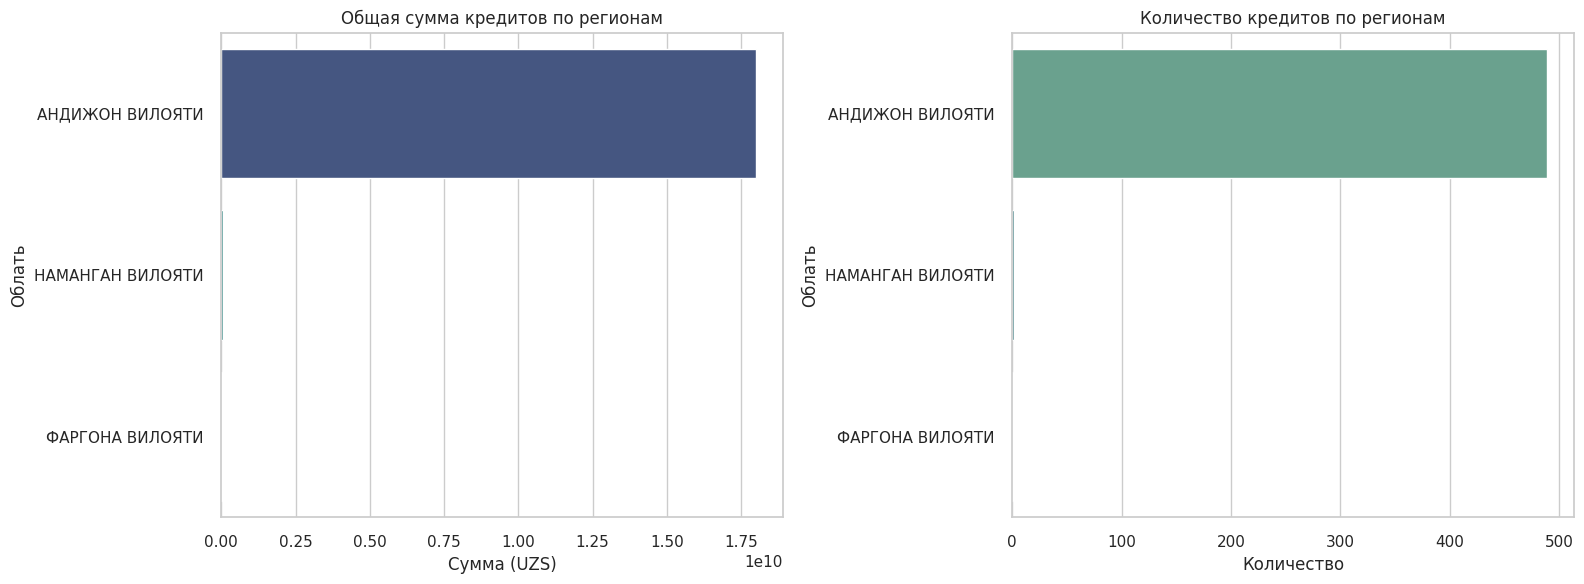

In [5]:
region_sum = df.groupby("Облать")["Сумма_num"].sum().sort_values(ascending=False)
region_count = df["Облать"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.barplot(y=region_sum.index, x=region_sum.values, ax=ax[0], palette="viridis")
ax[0].set_title("Общая сумма кредитов по регионам")
ax[0].set_xlabel("Сумма (UZS)")

sns.barplot(y=region_count.index, x=region_count.values, ax=ax[1], palette="crest")
ax[1].set_title("Количество кредитов по регионам")
ax[1].set_xlabel("Количество")

plt.tight_layout()
plt.savefig(REPORTS_DIR / "region_analysis.png", dpi=150)
plt.show()


/tmp/ipykernel_121190/2463921756.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=brand_sum.index, x=brand_sum.values, ax=ax[0], palette="mako")
/tmp/ipykernel_121190/2463921756.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=brand_count.index, x=brand_count.values, ax=ax[1], palette="flare")


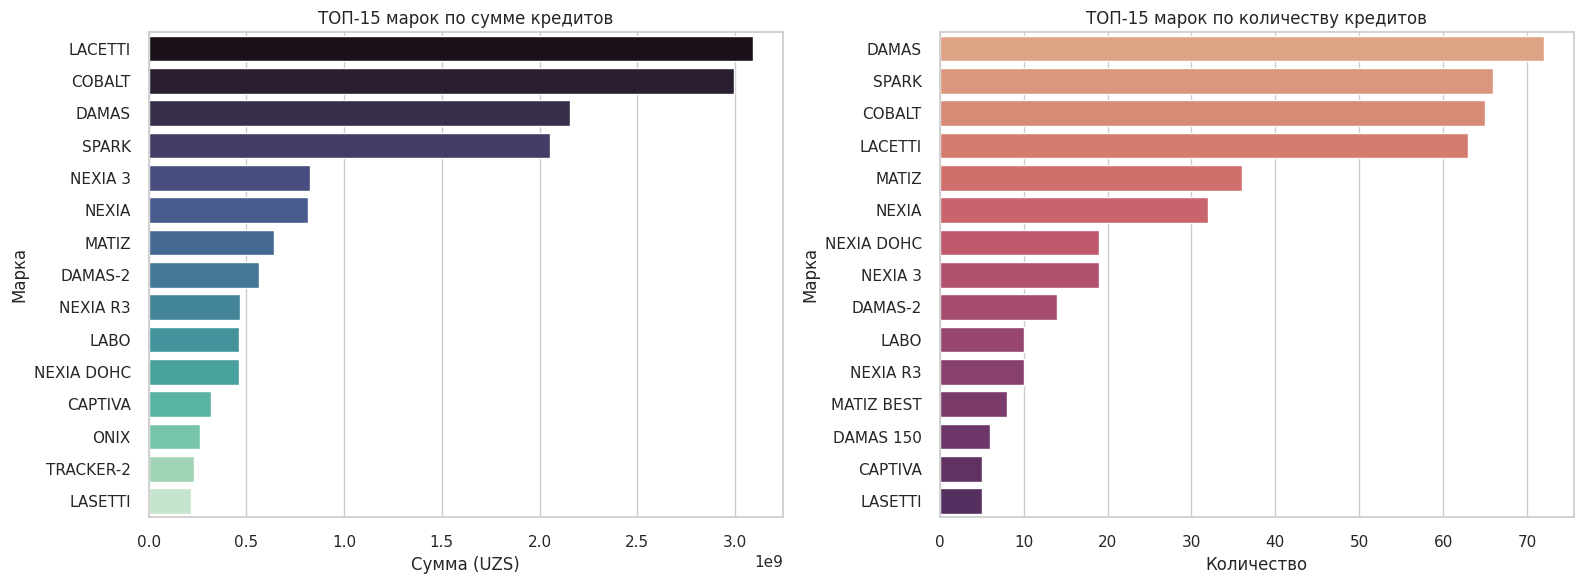

In [6]:
brand_sum = df.groupby("Марка")["Сумма_num"].sum().sort_values(ascending=False).head(15)
brand_count = df["Марка"].value_counts().head(15)

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.barplot(y=brand_sum.index, x=brand_sum.values, ax=ax[0], palette="mako")
ax[0].set_title("ТОП-15 марок по сумме кредитов")
ax[0].set_xlabel("Сумма (UZS)")

sns.barplot(y=brand_count.index, x=brand_count.values, ax=ax[1], palette="flare")
ax[1].set_title("ТОП-15 марок по количеству кредитов")
ax[1].set_xlabel("Количество")

plt.tight_layout()
plt.savefig(REPORTS_DIR / "brand_analysis.png", dpi=150)
plt.show()


/tmp/ipykernel_121190/3344936057.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Тип кузова", data=df, order=df["Тип кузова"].value_counts().index, palette="pastel")


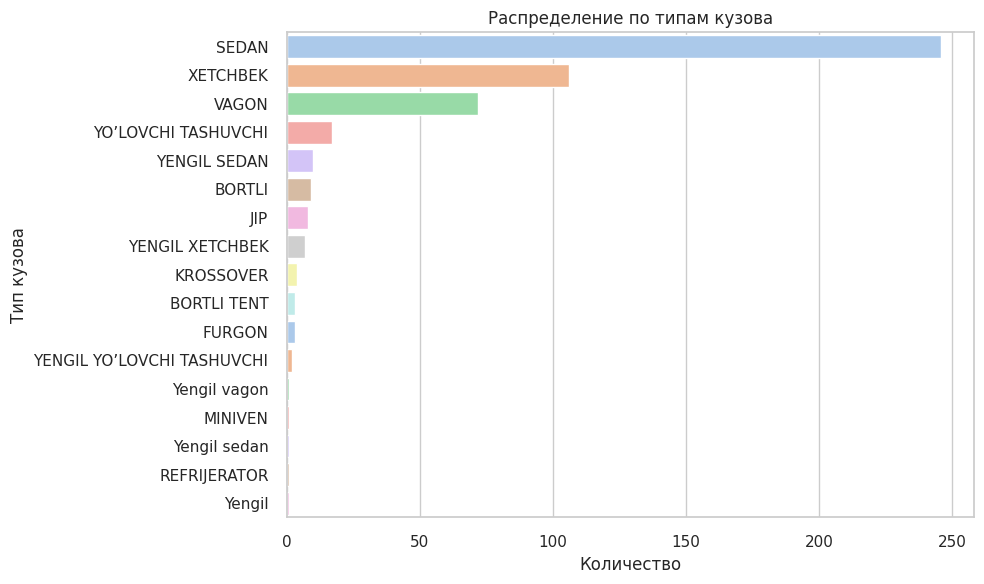

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(y="Тип кузова", data=df, order=df["Тип кузова"].value_counts().index, palette="pastel")
plt.title("Распределение по типам кузова")
plt.xlabel("Количество")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "bodytype.png", dpi=150)
plt.show()


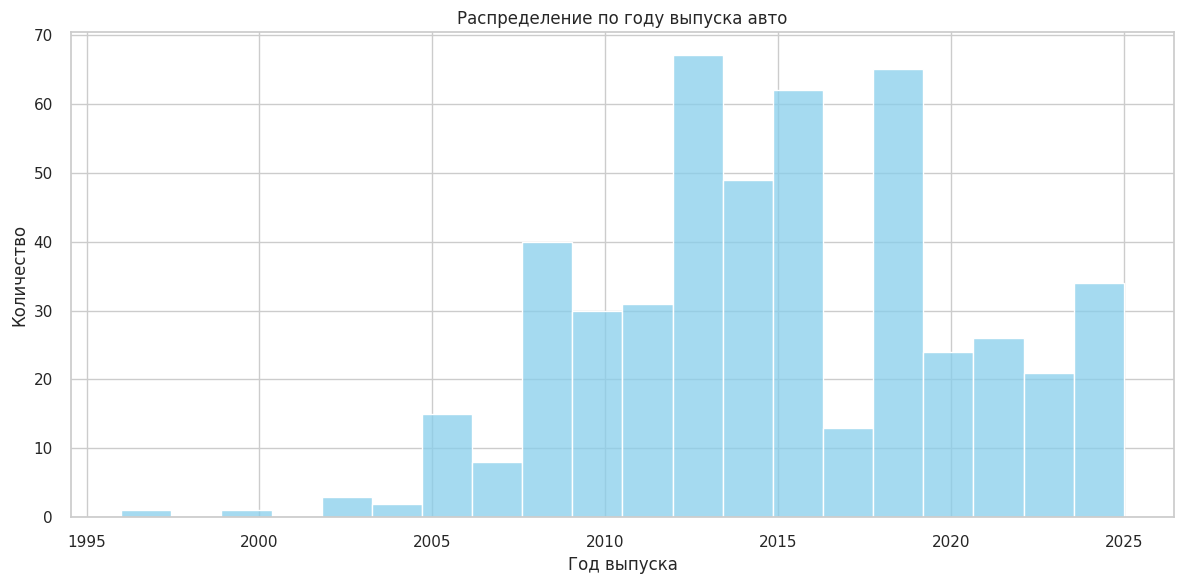

In [8]:
plt.figure(figsize=(12,6))
sns.histplot(df["Год выпуска"], bins=20, kde=False, color="skyblue")
plt.title("Распределение по году выпуска авто")
plt.xlabel("Год выпуска")
plt.ylabel("Количество")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "year_hist.png", dpi=150)
plt.show()


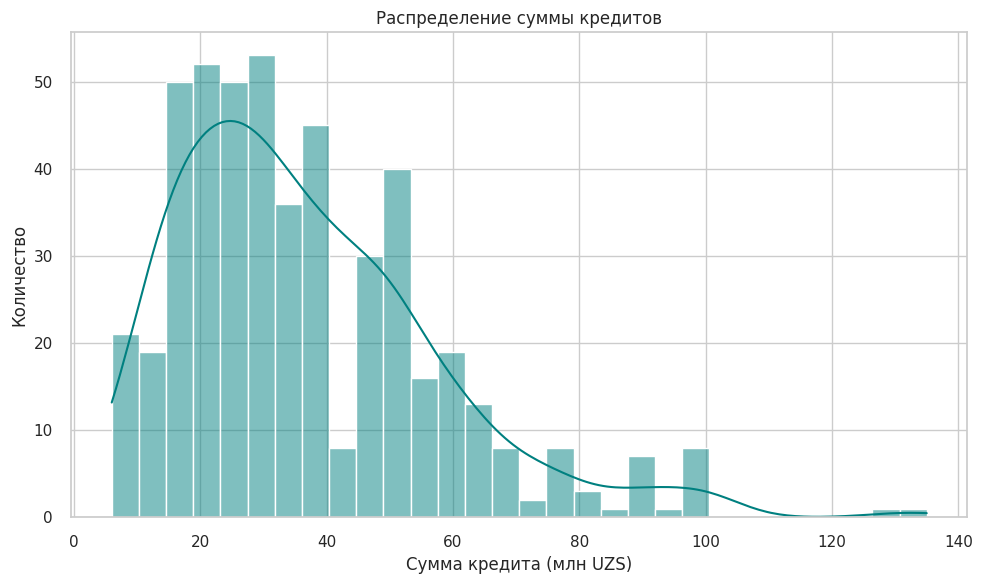

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(df["Сумма_num"]/1e6, bins=30, kde=True, color="teal")
plt.title("Распределение суммы кредитов")
plt.xlabel("Сумма кредита (млн UZS)")
plt.ylabel("Количество")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "loan_distribution.png", dpi=150)
plt.show()


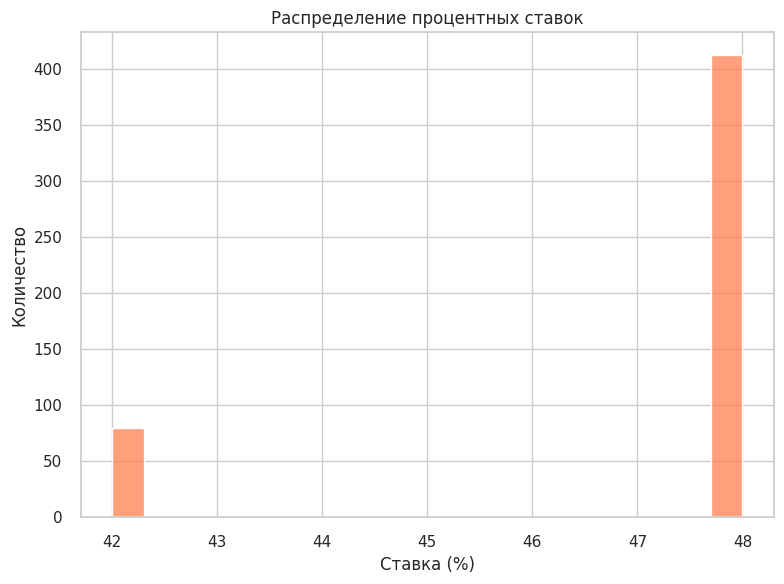

In [10]:
plt.figure(figsize=(8,6))
sns.histplot(df["% ставка"], bins=20, kde=False, color="coral")
plt.title("Распределение процентных ставок")
plt.xlabel("Ставка (%)")
plt.ylabel("Количество")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "rate_distribution.png", dpi=150)
plt.show()


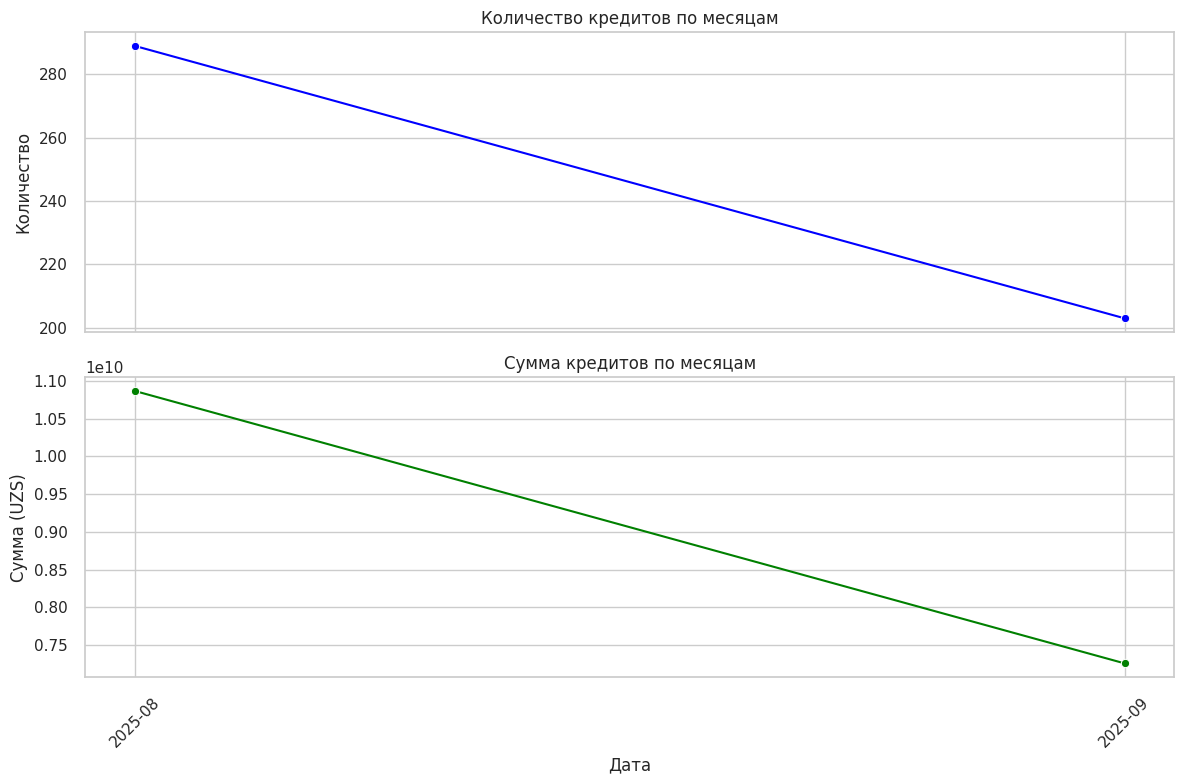

In [11]:
monthly = df.groupby(df["Дата"].dt.to_period("M")).agg({
    "Сумма_num":"sum",
    "Код":"count"
})
monthly.index = monthly.index.astype(str)

fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
sns.lineplot(x=monthly.index, y=monthly["Код"], marker="o", ax=ax[0], color="blue")
ax[0].set_title("Количество кредитов по месяцам")
ax[0].set_ylabel("Количество")
ax[0].tick_params(axis="x", rotation=45)

sns.lineplot(x=monthly.index, y=monthly["Сумма_num"], marker="o", ax=ax[1], color="green")
ax[1].set_title("Сумма кредитов по месяцам")
ax[1].set_ylabel("Сумма (UZS)")
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(REPORTS_DIR / "monthly_trends.png", dpi=150)
plt.show()


/tmp/ipykernel_121190/3426009379.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=avg_brand.index, x=avg_brand.values, palette="rocket")


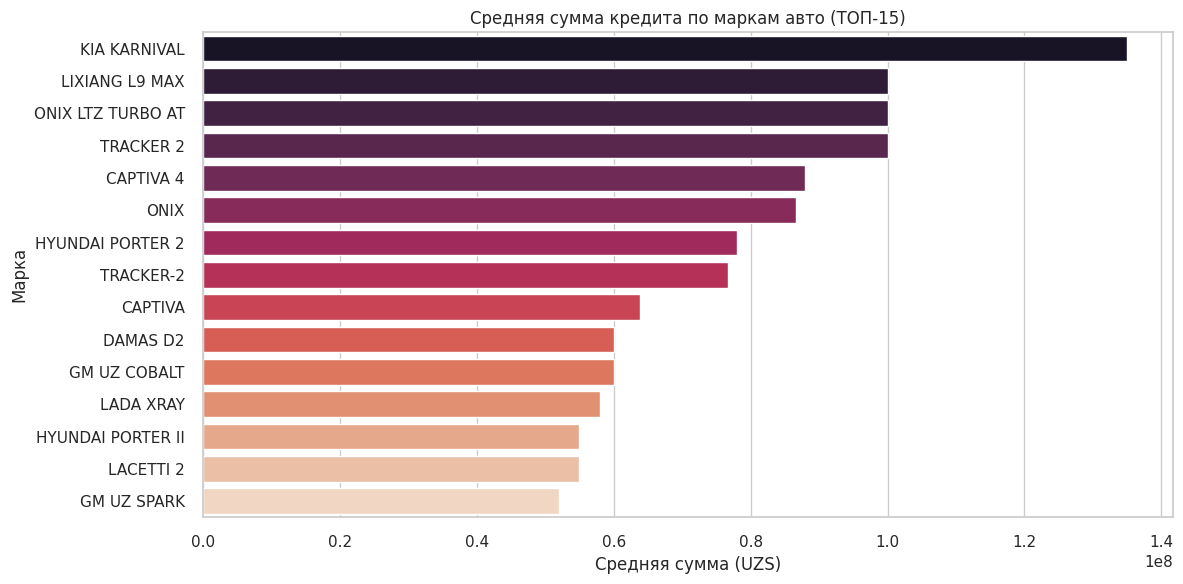

In [12]:
avg_brand = df.groupby("Марка")["Сумма_num"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(y=avg_brand.index, x=avg_brand.values, palette="rocket")
plt.title("Средняя сумма кредита по маркам авто (ТОП-15)")
plt.xlabel("Средняя сумма (UZS)")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "avg_loan_brand.png", dpi=150)
plt.show()


/tmp/ipykernel_121190/1284730307.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=avg_region.index, x=avg_region.values, palette="Spectral")


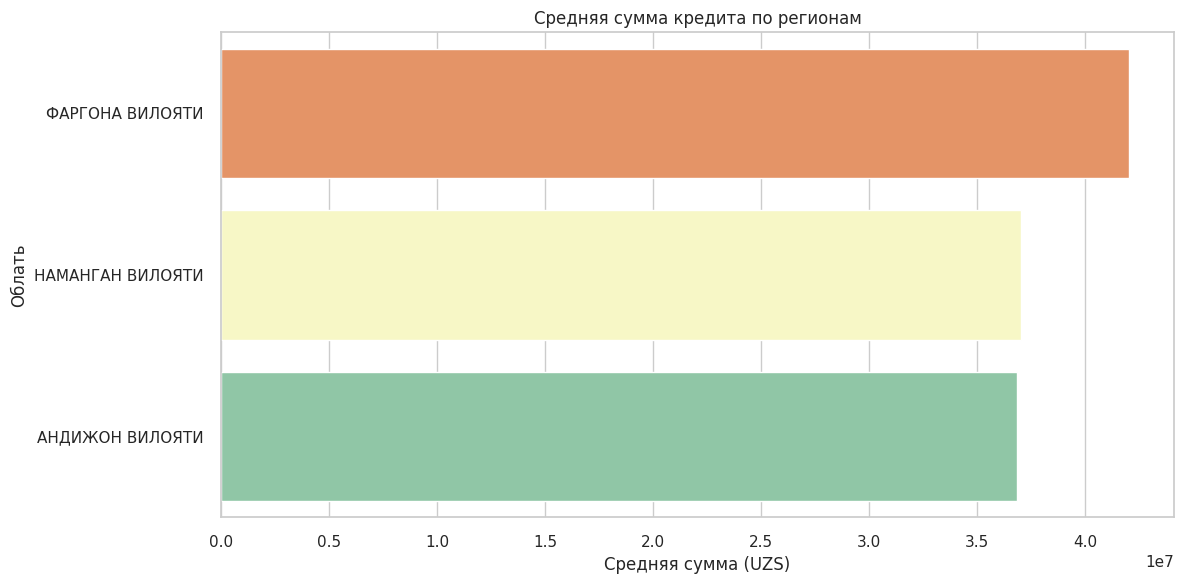

In [15]:
avg_region = df.groupby("Облать")["Сумма_num"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(y=avg_region.index, x=avg_region.values, palette="Spectral")
plt.title("Средняя сумма кредита по регионам")
plt.xlabel("Средняя сумма (UZS)")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "avg_loan_region.png", dpi=150)
plt.show()


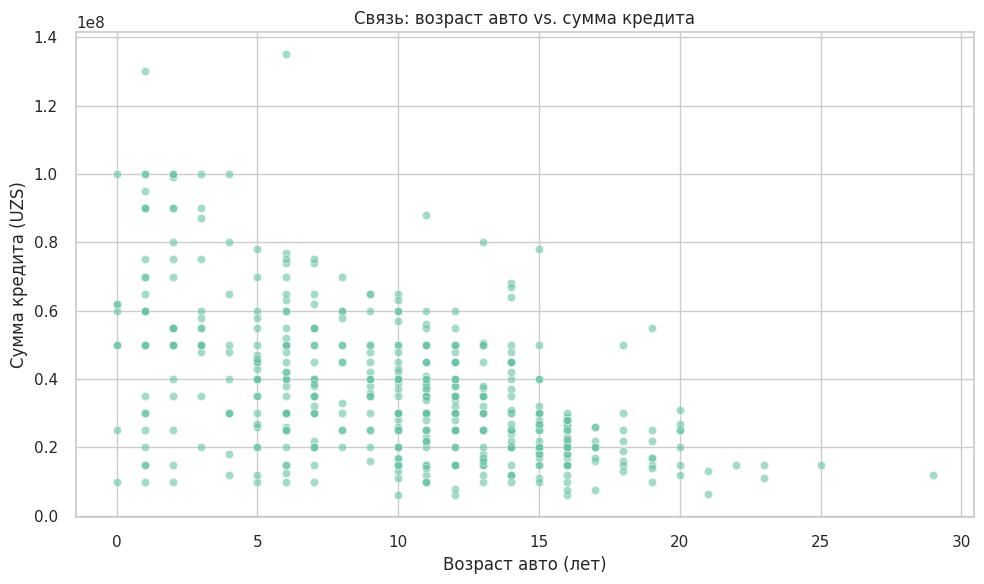

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Возраст авто", y="Сумма_num", data=df, alpha=0.6)
plt.title("Связь: возраст авто vs. сумма кредита")
plt.xlabel("Возраст авто (лет)")
plt.ylabel("Сумма кредита (UZS)")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "loan_vs_age.png", dpi=150)
plt.show()


In [19]:
REPORT_DIR = Path("report"); REPORTS_DIR.mkdir(exist_ok=True)

region_sum.to_csv(REPORT_DIR / "region_sum.csv")
brand_sum.to_csv(REPORT_DIR / "brand_sum.csv")
monthly.to_csv(REPORT_DIR / "monthly.csv")
print("All summaries & charts saved in 'report/' folder")


All summaries & charts saved in 'report/' folder
